### BADASS Analysis - can we tell the difference between butanoic acid, decanoic acid, palmitic acid, oleic acid and nervonic acid?

- Butanoic acid: C4, saturated
- Decanoic acid: C10, saturated
- Palmitic acid: C16, saturated
- Oleic acid: C18, 1x (Z) C=C bond
- Nervonic acid: C24, 1x (Z) C=C bond

In [1]:
from subroutines.parse_array_data import ParseArrayData
from subroutines.train import RunML

In [2]:
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)  # Sets default figure size

#### Parse in input data

Fatty acid data

In [3]:
fa_fluor_data = ParseArrayData(
    dir_path='/Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/',
    repeat_names=['repeat_1', 'repeat_2', 'repeat_3', 'repeat_4', 'repeat_5', 'repeat_6', 'repeat_7', 'repeat_8'],
    peptide_list=['No Pep', 'GRP22', 'GRP35', 'GRP46', 'GRP51', 'GRP52', 'GRP63', 'GRP80', 'Pent', 'Hex',
                  'Hex2', 'Hept', '24D', '24E', '24K', '17K'],
    results_dir='Analysis/Standard_array/FAs/',
    control_peptides=['GRP35'],
    control_analytes=['F', 'G']
)

Directory Analysis/Standard_array/FAs/ already found in /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing
Overwrite Analysis/Standard_array/FAs/?y


Locate xlsx files

In [4]:
fa_fluor_data.group_xlsx_repeats()

Read the data in each xlsx file into a dataframe and perform min-max scaling

In [5]:
fa_fluor_data.xlsx_to_scaled_df('No Pep')

Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/F_G_M_P_S_repeat_1.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/A_L_N_Ol_Pol_repeat_1.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/B_D_DD_H_O_repeat_1.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/B_D_DD_H_O_repeat_2.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/A_L_N_Ol_Pol_repeat_2.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/F_G_M_P_S_repeat_2.xlsx
Parsing plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/B_D_DD_H_O_repeat_3.xlsx
Parsing plate /Users/ks17361/Lab_work_D

Have checked data for Ol + GRP52 on plate /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Small_Molecules/FAs/Reformatted_FA_csvs/A_L_N_Ol_Pol_repeat_7.xlsx - the average fluorescence of Ol + DPH is slightly higher than that of Ol + GRP52 + DPH, but not concerningly so - the values are very similar, just indicates that Ol displaces effectivly all of the DPH from barrel GRP52.

Combines readings of the same analyte solution across different plates, then calculates the median reading for non-independent repeats of the same analyte 

In [6]:
fa_fluor_data.combine_plate_readings(outlier_excl_thresh=0.001, drop_thresh=1)

 Outlier excluded from final output dataset: M, 1 (flagged readings = GRP52: 0.14845257933411007, Hex: 0.17339789341803608) 
 Outlier excluded from final output dataset: A, 3 (flagged readings = GRP52: 0.017910495910393443) 


In [7]:
fa_fluor_data.ml_fluor_data

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K,Analyte
0,0.014612,6.863827,0.047253,0.004548,0.005614,0.367463,0.049632,0.079569,0.052441,0.157820,0.039129,0.019453,0.014918,0.338736,Ol
1,0.014909,4.127982,0.033587,0.004460,0.005237,0.312469,0.047465,0.082441,0.072220,0.166926,0.035686,0.017718,0.014622,0.414972,Ol
2,0.014888,4.210647,0.035680,0.005139,0.006797,0.333008,0.049610,0.087697,0.075076,0.159362,0.041200,0.019318,0.015627,0.435030,Ol
3,0.017162,6.065731,0.149018,0.005642,0.012619,0.665122,0.093306,0.104142,0.067662,0.365015,0.071919,0.050840,0.034860,0.500803,Ol
4,0.016735,5.170245,0.138293,0.008364,0.012619,0.610596,0.090259,0.128975,0.090677,0.405193,0.087373,0.046489,0.032722,0.657258,Ol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.902210,1.264846,0.902207,1.041539,1.062318,1.066535,1.027970,1.007852,0.342028,0.756861,1.131913,1.161931,1.083611,0.744000,O
98,0.900568,1.388206,0.953987,1.039095,1.009416,0.991309,0.981639,0.789289,0.360254,0.809902,1.085956,1.076413,1.125303,0.679420,O
99,0.832597,1.118913,1.039132,1.018919,0.979335,1.108629,1.001007,0.826539,0.669709,0.939844,1.048400,1.041467,1.027657,0.855077,O
100,0.786051,0.992958,0.992692,1.017162,1.000211,1.020913,0.914205,0.991285,0.583104,0.926578,0.981489,0.967274,0.834103,0.795996,O


Makes sub-dataframe of 5 analytes we are interested in distinguishing (too few data points to attempt to distinguish all 15 different fatty acids tested on the standard array)

In [8]:
sub_indices = [i for i in range(fa_fluor_data.ml_fluor_data.shape[0])
               if fa_fluor_data.ml_fluor_data['Analyte'][i] in ['B', 'DD', 'P', 'Ol', 'N']]
sub_fa_fluor_data = copy.deepcopy(fa_fluor_data.ml_fluor_data).iloc[sub_indices].reset_index(drop=True)

In [9]:
sub_fa_fluor_data

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K,Analyte
0,0.014612,6.863827,0.047253,0.004548,0.005614,0.367463,0.049632,0.079569,0.052441,0.157820,0.039129,0.019453,0.014918,0.338736,Ol
1,0.014909,4.127982,0.033587,0.004460,0.005237,0.312469,0.047465,0.082441,0.072220,0.166926,0.035686,0.017718,0.014622,0.414972,Ol
2,0.014888,4.210647,0.035680,0.005139,0.006797,0.333008,0.049610,0.087697,0.075076,0.159362,0.041200,0.019318,0.015627,0.435030,Ol
3,0.017162,6.065731,0.149018,0.005642,0.012619,0.665122,0.093306,0.104142,0.067662,0.365015,0.071919,0.050840,0.034860,0.500803,Ol
4,0.016735,5.170245,0.138293,0.008364,0.012619,0.610596,0.090259,0.128975,0.090677,0.405193,0.087373,0.046489,0.032722,0.657258,Ol
5,0.077423,4.217972,0.031071,0.005682,0.008298,0.455640,0.053788,0.190842,0.074751,0.146871,0.056542,0.024607,0.028809,0.517664,Ol
6,0.067571,5.059728,0.030975,0.004244,0.008193,0.371942,0.061006,0.100722,0.054419,0.129679,0.043942,0.020858,0.022955,0.331577,Ol
7,0.074921,5.233017,0.029127,0.004706,0.008387,0.339571,0.049065,0.144973,0.052679,0.152988,0.035500,0.017954,0.018816,0.376759,Ol
8,0.968681,1.132396,1.015122,0.985707,1.036878,1.049074,1.013192,0.933525,0.458490,0.796116,0.980610,0.989425,0.935957,1.004739,B
9,0.962459,1.172698,0.976221,0.981216,1.019847,0.989457,0.976434,0.811075,0.523563,0.920688,0.956988,0.985935,0.959658,1.249273,B


Generates "representative" fingerprint for each class (by calculating the median value for each feature)

Ol


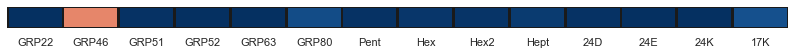

B


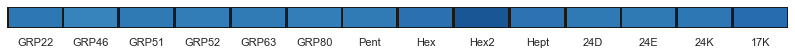

N


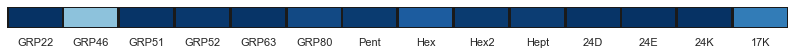

DD


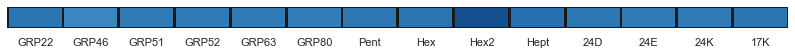

P


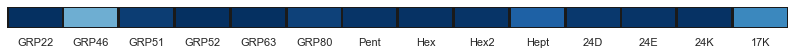

In [10]:
classes = []
for class_name in sub_fa_fluor_data['Analyte'].tolist():
    if not class_name in classes:
        classes.append(class_name)
sub_fa_fluor_data_x_val = sub_fa_fluor_data.drop(['Analyte'], axis=1)
vmin = sub_fa_fluor_data_x_val.values.min()
vmax = sub_fa_fluor_data_x_val.values.max()

for class_name in classes:
    print(class_name)
    class_indices = [n for n in range(sub_fa_fluor_data.shape[0])
                     if sub_fa_fluor_data['Analyte'][n] == class_name]
    repr_array = np.median(sub_fa_fluor_data_x_val.values[class_indices, :], axis=0)

    sns.set(rc={'figure.figsize':(14,0.4)})
    plt.clf()
    sns.heatmap(
        np.array([repr_array]), vmin=vmin, vmax=vmax, annot=False, cmap='RdBu_r', cbar=False,
        xticklabels=sub_fa_fluor_data_x_val.columns, yticklabels=False, linecolor='k', linewidths=2
    )
    plt.show()

Generates box plots to compare the distribution of values for each class across the 14 features

Oleic acid


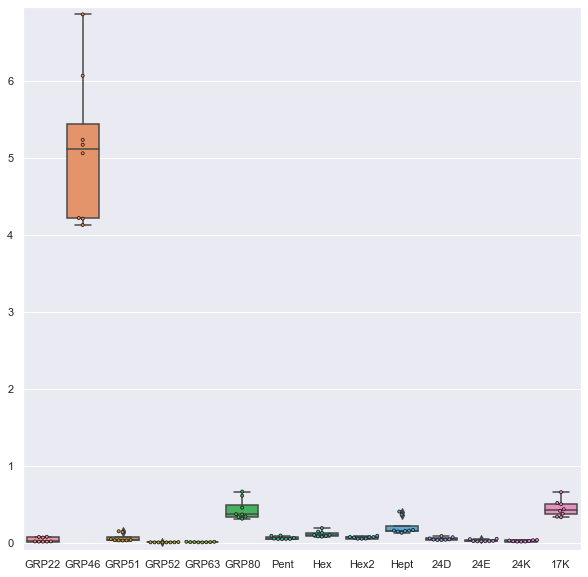

Nervonic acid


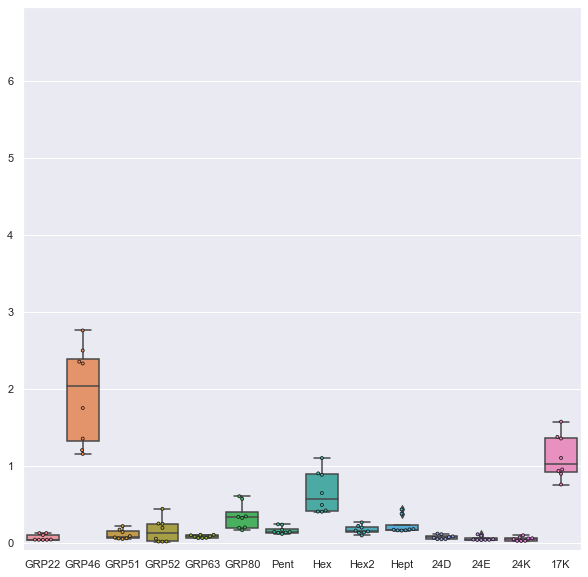

Palmitic acid


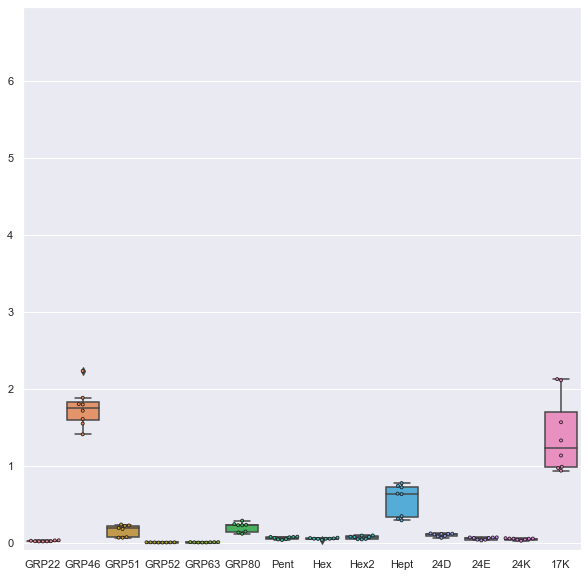

Butanoic acid


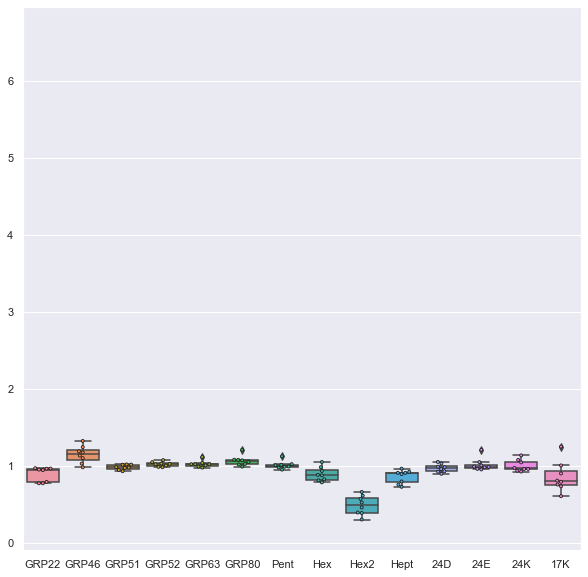

Dodecanoic acid


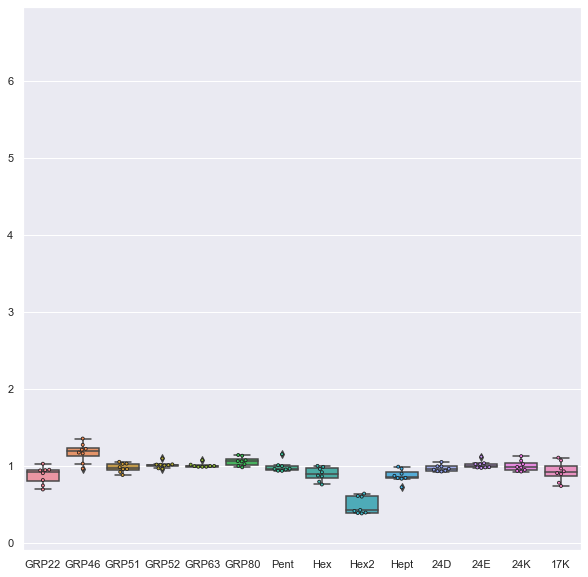

In [11]:
ymin = sub_fa_fluor_data.drop('Analyte', axis=1).min().min() - 0.1
ymax = sub_fa_fluor_data.drop('Analyte', axis=1).max().max() + 0.1

ol_indices = [int(i) for i in range(sub_fa_fluor_data.shape[0])
              if sub_fa_fluor_data['Analyte'][i] == 'Ol']
n_indices = [int(i) for i in range(sub_fa_fluor_data.shape[0])
             if sub_fa_fluor_data['Analyte'][i] == 'N']
p_indices = [int(i) for i in range(sub_fa_fluor_data.shape[0])
             if sub_fa_fluor_data['Analyte'][i] == 'P']
b_indices = [int(i) for i in range(sub_fa_fluor_data.shape[0])
             if sub_fa_fluor_data['Analyte'][i] == 'B']
dd_indices = [int(i) for i in range(sub_fa_fluor_data.shape[0])
              if sub_fa_fluor_data['Analyte'][i] == 'DD']

sns.set(rc={'figure.figsize':(10,10)})
print('Oleic acid')
plt.clf()
plt.ylim(ymin, ymax)
sns.boxplot(data=sub_fa_fluor_data.iloc[ol_indices])
sns.swarmplot(data=sub_fa_fluor_data.iloc[ol_indices], size=3, edgecolor='k', linewidth=0.8)
plt.show()

sns.set(rc={'figure.figsize':(10,10)})
print('Nervonic acid')
plt.clf()
plt.ylim(ymin, ymax)
sns.boxplot(data=sub_fa_fluor_data.iloc[n_indices])
sns.swarmplot(data=sub_fa_fluor_data.iloc[n_indices], size=3, edgecolor='k', linewidth=0.8)
plt.show()

sns.set(rc={'figure.figsize':(10,10)})
print('Palmitic acid')
plt.clf()
plt.ylim(ymin, ymax)
sns.boxplot(data=sub_fa_fluor_data.iloc[p_indices])
sns.swarmplot(data=sub_fa_fluor_data.iloc[p_indices], size=3, edgecolor='k', linewidth=0.8)
plt.show()

sns.set(rc={'figure.figsize':(10,10)})
print('Butanoic acid')
plt.clf()
plt.ylim(ymin, ymax)
sns.boxplot(data=sub_fa_fluor_data.iloc[b_indices])
sns.swarmplot(data=sub_fa_fluor_data.iloc[b_indices], size=3, edgecolor='k', linewidth=0.8)
plt.show()

sns.set(rc={'figure.figsize':(10,10)})
print('Dodecanoic acid')
plt.clf()
plt.ylim(ymin, ymax)
sns.boxplot(data=sub_fa_fluor_data.iloc[dd_indices])
sns.swarmplot(data=sub_fa_fluor_data.iloc[dd_indices], size=3, edgecolor='k', linewidth=0.8)
plt.show()

#### Run machine learning

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)  # Sets default figure size

#### - ML on subset of FA data (B, DD, P, Ol, N)

First split the data into a training and test set

In [74]:
ml = RunML(
    results_dir='/Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Analysis/Standard_array/FAs/'
                'Subset_FAs_3_components_ML_results/', fluor_data=sub_fa_fluor_data
)

Directory /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Analysis/Standard_array/FAs/Subset_FAs_3_components_ML_results/ already found in /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing
Overwrite /Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Analysis/Standard_array/FAs/Subset_FAs_3_components_ML_results/?n


In [14]:
ml.split_train_test_data(randomise=True, percent_test=0.2, test_analytes=[])

In [15]:
ml.train_y

array(['Ol', 'Ol', 'Ol', 'Ol', 'Ol', 'Ol', 'Ol', 'B', 'B', 'B', 'B', 'B',
       'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'DD', 'DD', 'DD', 'DD',
       'DD', 'DD', 'P', 'P', 'P', 'P', 'P', 'P'], dtype=object)

In [16]:
ml.test_y

array(['Ol', 'B', 'B', 'N', 'DD', 'DD', 'P', 'P'], dtype=object)

On all of the data (training and test sets):

- Visualise correlation between the initial 14 features

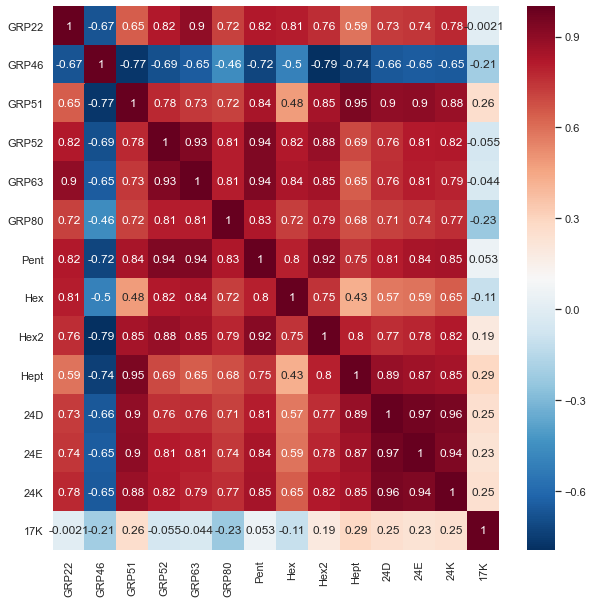

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
GRP22,1.000000,-0.669043,0.648218,0.822702,0.897373,0.715572,0.820450,0.809568,0.763227,0.588743,0.731895,0.743527,0.780300,-0.002064
GRP46,-0.669043,1.000000,-0.771107,-0.686304,-0.646529,-0.462101,-0.718574,-0.504503,-0.794934,-0.739587,-0.659099,-0.646154,-0.648780,-0.206379
GRP51,0.648218,-0.771107,1.000000,0.777861,0.734709,0.717261,0.844278,0.483114,0.845966,0.949343,0.896623,0.904503,0.880300,0.260976
GRP52,0.822702,-0.686304,0.777861,1.000000,0.933771,0.809193,0.942026,0.820263,0.884428,0.692683,0.759475,0.812946,0.822326,-0.054972
GRP63,0.897373,-0.646529,0.734709,0.933771,1.000000,0.806754,0.942589,0.836585,0.854409,0.645028,0.761914,0.806942,0.793058,-0.044090
GRP80,0.715572,-0.462101,0.717261,0.809193,0.806754,1.000000,0.830957,0.723077,0.785366,0.678424,0.713133,0.739400,0.766041,-0.228705
Pent,0.820450,-0.718574,0.844278,0.942026,0.942589,0.830957,1.000000,0.801313,0.921388,0.752908,0.805066,0.841088,0.851407,0.053096
Hex,0.809568,-0.504503,0.483114,0.820263,0.836585,0.723077,0.801313,1.000000,0.752158,0.425141,0.572983,0.588368,0.647280,-0.105816
Hex2,0.763227,-0.794934,0.845966,0.884428,0.854409,0.785366,0.921388,0.752158,1.000000,0.799062,0.766041,0.784053,0.819887,0.187992
Hept,0.588743,-0.739587,0.949343,0.692683,0.645028,0.678424,0.752908,0.425141,0.799062,1.000000,0.886867,0.866041,0.851782,0.286492


In [17]:
ml.calc_feature_correlations(train_data=ml.fluor_data)

- Measure the relative importances of the initial 14 features

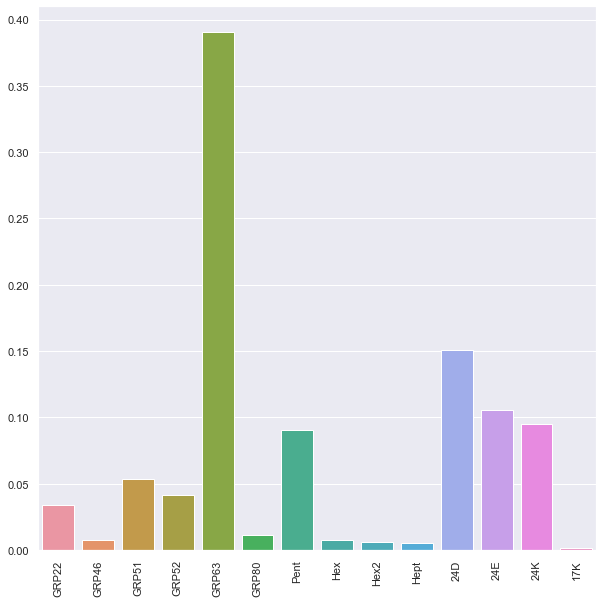

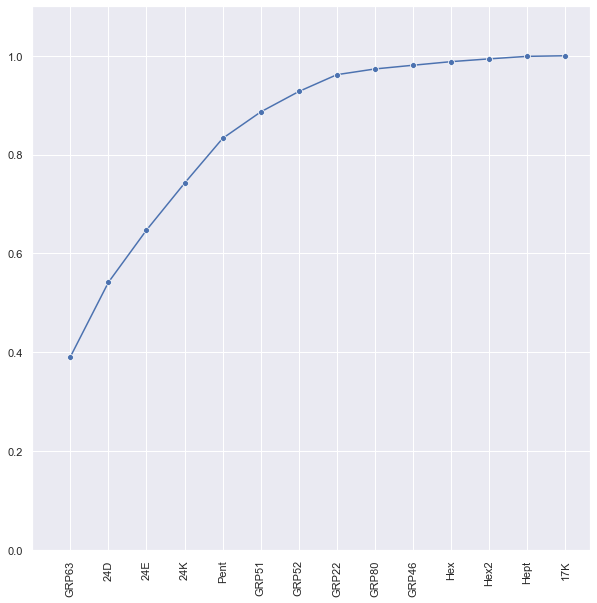

,Feature,Score
0,GRP63,0.390478
1,24D,0.150899
2,24E,0.105747
3,24K,0.094977
4,Pent,0.090672
5,GRP51,0.053561
6,GRP52,0.041310
7,GRP22,0.034070
8,GRP80,0.011567
9,GRP46,0.007511


In [18]:
from sklearn.feature_selection import f_classif
ml.calc_feature_importances_kbest(x_train=ml.x, y_train=ml.y, features=ml.features, method_classif=f_classif)

- Run PCA to determine the number of components to use in all following cross-validation splits

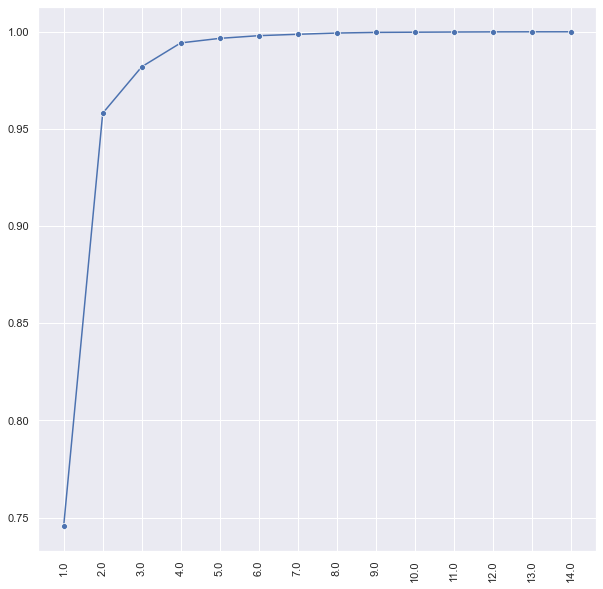

In [19]:
all_features_pca = ml.run_pca(x_train=ml.x, features=ml.features)

Contributions of the 14 barrels to each principal component (see the Scree plot above for how much of the signal in the data is explained by successive principal components)

In [20]:
pca_components = OrderedDict({'Component': [int(n) for n in range(1, 15)]})
for index, feature in enumerate(ml.features):
    pca_components[feature] = all_features_pca.components_[:,index]
pca_components = pd.DataFrame(pca_components)
pca_components = pca_components.set_index('Component', drop=True)

In [21]:
pca_components

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
Component,,,,,,,,,,,,,,
1,-0.182717,0.770659,-0.194955,-0.217695,-0.216316,-0.138990,-0.200181,-0.155398,-0.088214,-0.133091,-0.196592,-0.212189,-0.209915,-0.061138
2,0.229240,0.594688,0.218867,0.240824,0.260643,0.267149,0.239591,0.132496,0.090131,0.089508,0.234794,0.259987,0.257548,-0.261621
3,-0.007546,0.187908,0.152658,-0.066427,0.001374,0.113402,0.020338,-0.215872,0.053595,0.424447,0.068427,0.045973,0.044171,0.827808
4,0.007128,0.084868,-0.111946,-0.066931,-0.018603,0.136001,0.025732,0.865663,0.081690,-0.253755,-0.082528,-0.074536,-0.078083,0.342534
5,-0.570090,-0.035796,0.143098,0.135328,-0.098808,0.335868,0.043295,0.005599,0.619337,0.184889,-0.145620,-0.198474,-0.066478,-0.166342
6,0.051115,0.045012,-0.033782,0.628537,0.144737,-0.107334,0.089317,-0.271415,0.194096,-0.580399,-0.115101,-0.054520,-0.097508,0.291176
7,-0.109815,-0.059685,-0.137843,0.134028,-0.117309,0.741688,0.114613,-0.121543,-0.537852,-0.076669,-0.150981,0.070523,-0.180788,0.005145
8,-0.076651,0.045957,0.084809,0.586692,-0.066099,-0.328920,0.016471,0.256550,-0.322098,0.495872,-0.131125,-0.140180,-0.266043,-0.068603
9,-0.660725,0.029049,-0.229430,0.103197,-0.050850,-0.214652,0.072743,0.059304,-0.215373,-0.097727,0.181867,0.351032,0.471481,0.085508


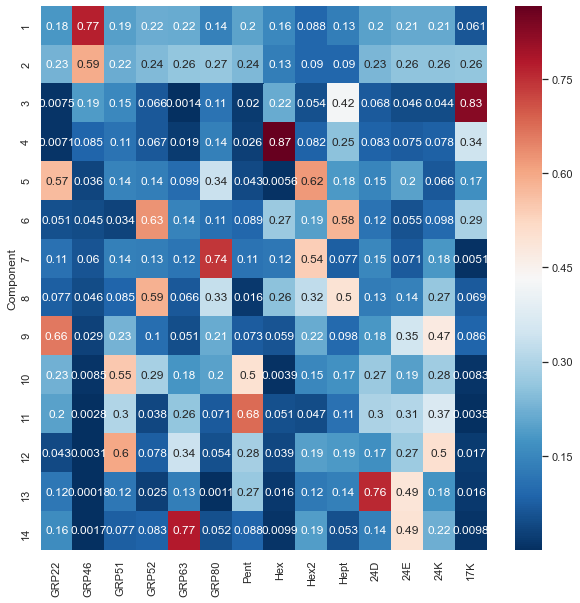

In [22]:
sns.heatmap(data=pca_components.abs(), cmap='RdBu_r', annot=True, xticklabels=True, yticklabels=True)

Relative contribution to the different components of each barrel

In [23]:
col_sums = copy.deepcopy(pca_components).abs().sum(axis=0)
relative_pca_components = copy.deepcopy(pca_components.abs()).div(col_sums, axis=1)

In [24]:
relative_pca_components

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
Component,,,,,,,,,,,,,,
1,0.069191,0.412113,0.065845,0.080801,0.081308,0.050393,0.075709,0.070504,0.030343,0.044467,0.066827,0.067022,0.065325,0.028246
2,0.086809,0.318012,0.073921,0.089385,0.097970,0.096859,0.090614,0.060113,0.031003,0.029906,0.079813,0.082119,0.080148,0.120869
3,0.002858,0.100485,0.051560,0.024656,0.000517,0.041115,0.007692,0.097941,0.018435,0.141812,0.023260,0.014521,0.013746,0.382446
4,0.002699,0.045383,0.037809,0.024843,0.006992,0.049309,0.009732,0.392749,0.028099,0.084782,0.028054,0.023543,0.024299,0.158250
5,0.215882,0.019142,0.048331,0.050229,0.037139,0.121773,0.016374,0.002540,0.213035,0.061774,0.049501,0.062690,0.020688,0.076850
6,0.019356,0.024070,0.011410,0.233291,0.054403,0.038915,0.033780,0.123141,0.066764,0.193918,0.039126,0.017221,0.030344,0.134523
7,0.041585,0.031917,0.046556,0.049746,0.044094,0.268909,0.043347,0.055144,0.185007,0.025616,0.051323,0.022275,0.056261,0.002377
8,0.029026,0.024576,0.028644,0.217760,0.024845,0.119254,0.006229,0.116396,0.110793,0.165677,0.044573,0.044277,0.082792,0.031695
9,0.250204,0.015534,0.077489,0.038303,0.019113,0.077825,0.027511,0.026906,0.074082,0.032652,0.061822,0.110877,0.146723,0.039504


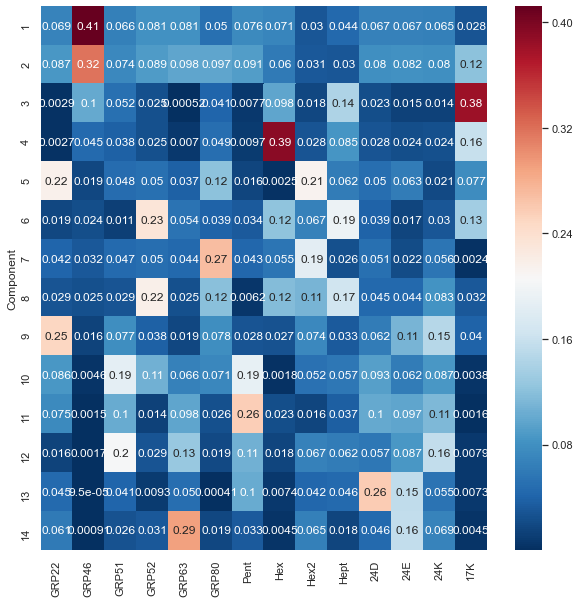

In [25]:
sns.heatmap(data=relative_pca_components.abs(), cmap='RdBu_r', annot=True, xticklabels=True, yticklabels=True)

Scatter plots of data transformed to PCA dimensions

In [70]:
def plot_scatter(x_data, y_data, dimensions, categories, results_dir, plot_id):
    """
    """
    
    from matplotlib.colors import BASE_COLORS, CSS4_COLORS
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    colours = [key for key, val in BASE_COLORS.items()]
    extra_colours = [key for key, val in CSS4_COLORS.items()]
    random.shuffle(extra_colours)
    colours += extra_colours
    markers = ['o', 'x', '^', '*']

    cat_colours = {}
    cat_markers = {}
    for index, cat in enumerate(categories):
        if index == 0:
            current_colour = colours[index]
            cat_colours[cat] = current_colour
            marker_count = 0
            cat_markers[cat] = markers[marker_count]
        else:
            if categories[index-1] == cat:
                cat_colours[cat] = current_colour
                cat_markers[cat] = markers[marker_count]
            elif categories[index-1].split('_')[0] == cat.split('_')[0]:
                cat_colours[cat] = current_colour
                marker_count += 1
                cat_markers[cat] = markers[marker_count]
            else:
                current_colour = colours[index]
                cat_colours[cat] = current_colour
                marker_count = 0
                cat_markers[cat] = markers[marker_count] 

    fig = plt.figure()
    if dimensions == 2:
        ax = fig.add_subplot(111)
        for i, y in np.ndenumerate(y_data):
            scatter = ax.scatter(x_data[i[0],0], x_data[i[0],1], c=cat_colours[y], marker=cat_markers[y])
    elif dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')
        for i, y in np.ndenumerate(y_data):
            scatter = ax.scatter(x_data[i[0],0], x_data[i[0],1], x_data[i[0],2], c=cat_colours[y],
                                 marker=cat_markers[y])

    legend_elements = []
    for cat, colour in cat_colours.items():
        marker = cat_markers[cat]
        legend_elements.append(Line2D([0], [0], marker=marker, color=colour, label=cat, markerfacecolor=colour))
    ax.legend(handles=legend_elements, loc='upper right', title='Classes')

    plt.savefig('{}/{}_{}_PCA_plot.svg'.format(results_dir, plot_id, str(dimensions)))
    plt.show()

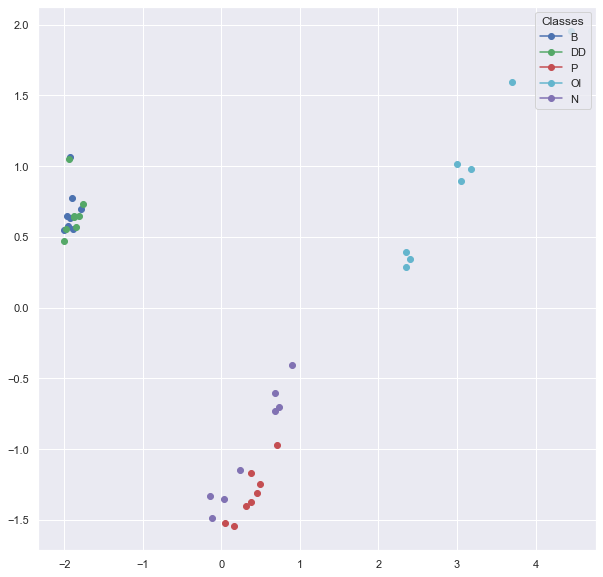

In [75]:
# Runs PCA and transforms data to 2 dimensions 
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)
pca_fitted_2d = pca_2d.fit(X=ml.x)
X_reduced_2d = pca_fitted_2d.transform(X=ml.x)

# Plots transformed data on 3D scatter plot
x_train_pca_2d = plot_scatter(
    x_data=X_reduced_2d, y_data=ml.y, dimensions=2, categories=['B', 'DD', 'P', 'Ol', 'N'],
    results_dir=ml.results_dir, plot_id='All_data_2D'
)

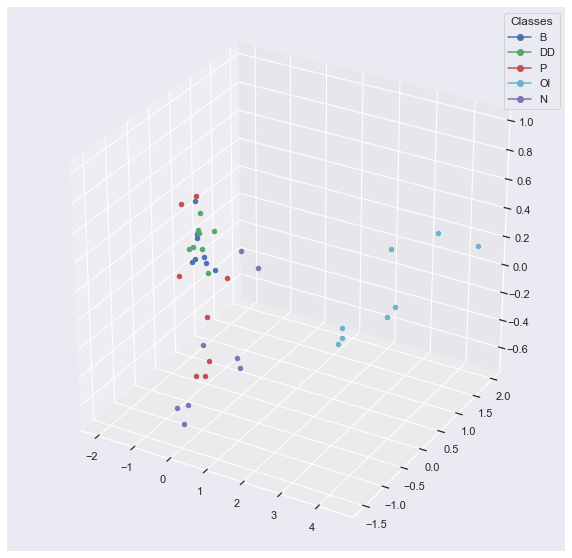

In [28]:
# Runs PCA and transforms data to 3 dimensions 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_fitted = pca.fit(X=ml.x)
X_reduced = pca_fitted.transform(X=ml.x)

# Plots transformed data on 3D scatter plot
x_train_pca = plot_scatter(
    x_data=X_reduced, y_data=ml.y, dimensions=3, categories=['B', 'DD', 'P', 'Ol', 'N'],
    results_dir=ml.results_dir, plot_id='All_data_3D'
)

~98% of the variation in the data can be accounted for with 3 features, so will transform the data to 3 (rather than 14) features

In [29]:
n_components = 3

Runs randomized search to spot check 5 different ML algorithms with 25 different combinations of the parameters to be optimised. Cross-validation loop involves:
- standardisation of the data (i.e. subtraction of the mean and division by the standard deviation) for each feature
- transformation to 3 orthogonal dimensions using PCA
- randomized search of 25 different hyperparameter combinations for the selected ML algorithm

In [30]:
cv_folds = 5
n_iter = 25  # Number of parameter combinations to test in RandomisedSearchCV

resampling_methods = ['no_balancing']

score_dict = OrderedDict({'Algorithm': [],
                          'Resampling_method': [],
                          'Best_params': [],
                          'Best_accuracy_score': [],
                          'Mean_accuracy_score': [],
                          'Std_dev_accuracy_score': []})

log_reg = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)
linear_svc = LinearSVC(dual=False)
svc = SVC()
naive_bayes = GaussianNB()

algorithms = [log_reg, knn, naive_bayes, linear_svc, svc]
for algorithm in algorithms:
    params = ml.define_tuned_model_params(clf=algorithm, x_train=ml.train_x)
    spot_checks, *_ = ml.run_algorithm(
        clf=algorithm, x_train=ml.train_x, y_train=ml.train_y, train_groups=ml.train_groups, x_test=ml.test_x,
        y_test=ml.test_y, n_components_pca=n_components, run='randomsearch', params=params,
        train_scoring_func='accuracy', test_scoring_funcs=None, resampling_method=resampling_methods,
        n_iter=n_iter, cv_folds=cv_folds
    )

    for method, spot_check in spot_checks.items():
        score_dict['Algorithm'].append(type(algorithm).__name__)
        score_dict['Resampling_method'].append(method)
        score_dict['Best_params'].append(spot_check.best_params_)
        score_dict['Best_accuracy_score'].append(spot_check.best_score_)
        score_dict['Mean_accuracy_score'].append(np.nanmean(spot_check.cv_results_['mean_test_score']))
        score_dict['Std_dev_accuracy_score'].append(np.nanmean(spot_check.cv_results_['std_test_score']))

        print('\n\n\n\n\n')
        print('{}: {}'.format(type(algorithm).__name__, method))
        print('Best parameters: {}'.format(spot_check.best_params_))
        print('Best score: {}'.format(spot_check.best_score_))

        selected_params = spot_check.cv_results_['params']
        selected_params_score = spot_check.cv_results_['mean_test_score']
        print('All parameter combinations tested:')
        for i in range(len(selected_params)):
            print(i+1, selected_params[i], round(selected_params_score[i], 3))
        
score_df = pd.DataFrame(score_dict)

Randomised search with cross-validation results:
Best parameters: {'LogisticRegression__solver': 'newton-cg', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 10.0}
Best score: 0.6904761904761905






LogisticRegression: no_balancing
Best parameters: {'LogisticRegression__solver': 'newton-cg', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 10.0}
Best score: 0.6904761904761905
All parameter combinations tested:
1 {'LogisticRegression__solver': 'saga', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 10.0} 0.624
2 {'LogisticRegression__solver': 'saga', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'ovr', 'LogisticRegression__C': 3162.2776601683795} 0.567
3 {'LogisticRegression__solver': 'lbfgs', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'ovr', 

Randomised search with cross-validation results:
Best parameters: {'SVC__gamma': 1.4142135623730951, 'SVC__C': 2.0}
Best score: 0.7476190476190476






SVC: no_balancing
Best parameters: {'SVC__gamma': 1.4142135623730951, 'SVC__C': 2.0}
Best score: 0.7476190476190476
All parameter combinations tested:
1 {'SVC__gamma': 0.001953125, 'SVC__C': 5.656854249492381} 0.471
2 {'SVC__gamma': 8.0, 'SVC__C': 23170.47500592079} 0.624
3 {'SVC__gamma': 8.631674575031098e-05, 'SVC__C': 16.0} 0.19
4 {'SVC__gamma': 0.0006905339660024879, 'SVC__C': 0.25} 0.19
5 {'SVC__gamma': 0.0078125, 'SVC__C': 22.627416997969522} 0.69
6 {'SVC__gamma': 0.015625, 'SVC__C': 0.03125} 0.19
7 {'SVC__gamma': 0.0009765625, 'SVC__C': 45.254833995939045} 0.657
8 {'SVC__gamma': 1.4142135623730951, 'SVC__C': 2.0} 0.748
9 {'SVC__gamma': 0.5, 'SVC__C': 0.0625} 0.19
10 {'SVC__gamma': 0.25, 'SVC__C': 0.04419417382415922} 0.19
11 {'SVC__gamma': 0.3535533905932738, 'SVC__C': 8192.0} 0.748
12 {'SVC__gamma': 0.011048543456039806, 'SVC__

In [31]:
score_df

,Algorithm,Resampling_method,Best_params,Best_accuracy_score,Mean_accuracy_score,Std_dev_accuracy_score
0,LogisticRegression,no_balancing,"{'LogisticRegression__solver': 'newton-cg', 'L...",0.690476,0.645238,0.122253
1,KNeighborsClassifier,no_balancing,"{'KNeighborsClassifier__weights': 'uniform', '...",0.819048,0.738810,0.104771
2,GaussianNB,no_balancing,{},0.714286,0.714286,0.128660
3,LinearSVC,no_balancing,{'LinearSVC__C': 32.0},0.723810,0.686667,0.122266
4,SVC,no_balancing,"{'SVC__gamma': 1.4142135623730951, 'SVC__C': 2.0}",0.747619,0.478476,0.081882


So, from this spot check, a **k nearest neighbours classifier** does a good job.

So, run hyperparameter optimisation for KNN.

In [32]:
fixed_params = ml.define_fixed_model_params(clf=KNeighborsClassifier())
random_tuned_params = ml.define_tuned_model_params(clf=KNeighborsClassifier(), x_train=ml.train_x)

knn_random_search = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='random search', fixed_params=fixed_params,
    tuned_params=random_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Randomised search with cross-validation results:
Best parameters: {'KNeighborsClassifier__weights': 'distance', 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__n_neighbors': 3}
Best score: 0.8476190476190476


In [33]:
grid_tuned_params = {'n_neighbors': [int(n) for n in np.linspace(2, 20, 19)],
                     'p': np.array([1, 2]),
                     'weights': ['uniform', 'distance']}

knn_grid_search = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='grid search', fixed_params=fixed_params,
    tuned_params=grid_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Grid search with cross-validation results:
Best parameters: {'KNeighborsClassifier__n_neighbors': 4, 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__weights': 'uniform'}
Best score: 0.7523809523809525


Best score following grid search is actually worse than the best score obtained following random search. However, it's important to remember that the scores obtained will show some variation depending upon how the data is randomly split up during cross-validation (furthermore, this variation will be exacerbated by the fact that the dataset is small in this case - e.g. see the range of accuracy scores obtained during cross-validation below).

### So, optimal hyperparameter combination:
- n_neighbors = 4
- p = 1
- weights = 'uniform'

Model cross-validation score: [0.71428571 0.71428571 0.66666667 1.         0.83333333]
accuracy_score: 0.75
recall_score: 0.8
precision_score: 0.8333333333333333
f1_score: 0.76
cohen_kappa_score: 0.6862745098039216
None


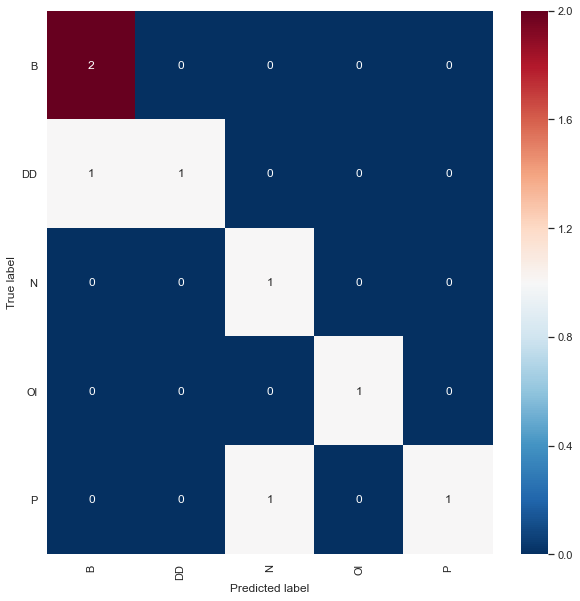

true


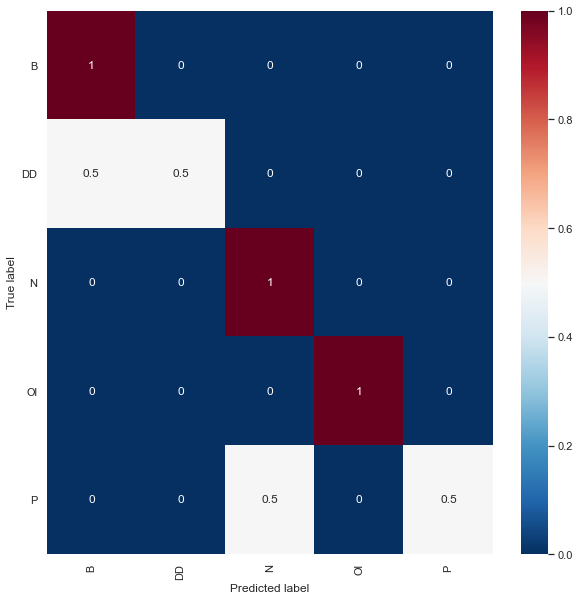

pred


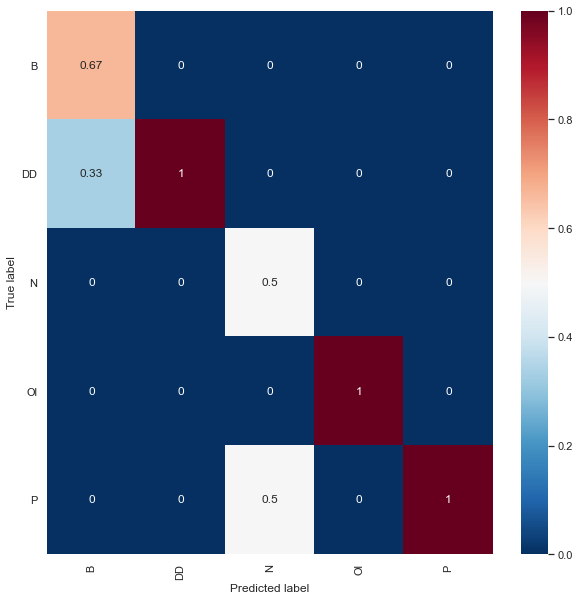

In [35]:
final_params = {'n_neighbors': 4,
                'p': 1,
                'weights': 'uniform'}

scoring_funcs={accuracy_score: {},
               recall_score: {'average': 'macro'},
               precision_score: {'average': 'macro'},
               f1_score: {'average': 'macro'},
               cohen_kappa_score: {}}

knn_clf, train_scores, test_scores, predictions = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='train', fixed_params=fixed_params,
    tuned_params=final_params, train_scoring_func='accuracy', test_scoring_funcs=scoring_funcs,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

How well does the trained classifier predict the different classes?

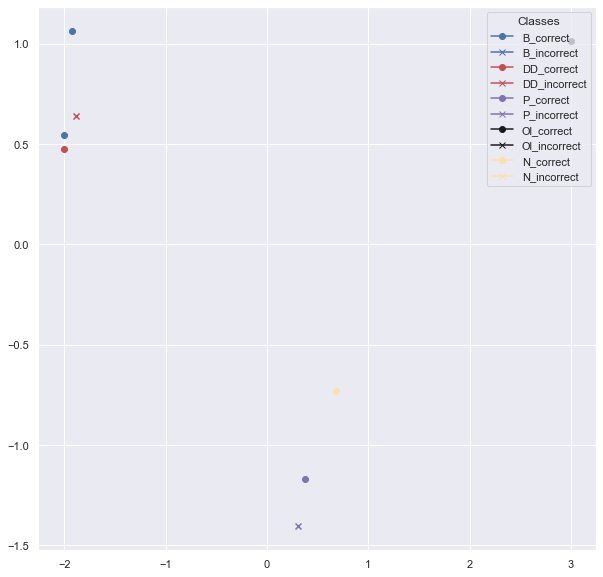

In [36]:
X_test_reduced = pca_fitted.transform(X=ml.test_x)
y_test_pred_hue = []
for index, y in np.ndenumerate(ml.test_y):
    if predictions[index] == y:
        y_test_pred_hue.append('{}_correct'.format(y))
    else:
        y_test_pred_hue.append('{}_incorrect'.format(y))

# Plots transformed data on 2D scatter plot
x_train_pca = plot_scatter(
    x_data=X_test_reduced, y_data=y_test_pred_hue, dimensions=2,
    categories=['B_correct', 'B_incorrect', 'DD_correct', 'DD_incorrect', 'P_correct', 'P_incorrect',
                'Ol_correct', 'Ol_incorrect', 'N_correct', 'N_incorrect'],
    results_dir=ml.results_dir, plot_id='Test_data'
)

#### - ML on FA data with 14 PCA components

In [37]:
ml = RunML(
    results_dir='/Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Analysis/Standard_array/FAs/'
                'Subset_FAs_14_components_ML_results/', fluor_data=sub_fa_fluor_data
)

In [38]:
ml.split_train_test_data(randomise=True, percent_test=0.2, test_analytes=[])

In [39]:
n_components = 14

Runs randomized search to spot check 5 different ML algorithms with 25 different combinations of the parameters to be optimised. Cross-validation loop involves:
- standardisation of the data (i.e. subtraction of the mean and division by the standard deviation) for each feature
- transformation to 14 orthogonal dimensions using PCA
- randomized search of 25 different hyperparameter combinations for the selected ML algorithm

In [40]:
cv_folds = 5
n_iter = 25  # Number of parameter combinations to test in RandomisedSearchCV

resampling_methods = ['no_balancing']

score_dict = OrderedDict({'Algorithm': [],
                          'Resampling_method': [],
                          'Best_params': [],
                          'Best_accuracy_score': [],
                          'Mean_accuracy_score': [],
                          'Std_dev_accuracy_score': []})

log_reg = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)
linear_svc = LinearSVC(dual=False)
svc = SVC()
naive_bayes = GaussianNB()

algorithms = [log_reg, knn, naive_bayes, linear_svc, svc]
for algorithm in algorithms:
    params = ml.define_tuned_model_params(clf=algorithm, x_train=ml.train_x)
    spot_checks, *_ = ml.run_algorithm(
        clf=algorithm, x_train=ml.train_x, y_train=ml.train_y, train_groups=ml.train_groups, x_test=ml.test_x,
        y_test=ml.test_y, n_components_pca=n_components, run='randomsearch', params=params,
        train_scoring_func='accuracy', test_scoring_funcs=None, resampling_method=resampling_methods,
        n_iter=n_iter, cv_folds=cv_folds
    )

    for method, spot_check in spot_checks.items():
        score_dict['Algorithm'].append(type(algorithm).__name__)
        score_dict['Resampling_method'].append(method)
        score_dict['Best_params'].append(spot_check.best_params_)
        score_dict['Best_accuracy_score'].append(spot_check.best_score_)
        score_dict['Mean_accuracy_score'].append(np.nanmean(spot_check.cv_results_['mean_test_score']))
        score_dict['Std_dev_accuracy_score'].append(np.nanmean(spot_check.cv_results_['std_test_score']))

        print('\n\n\n\n\n')
        print('{}: {}'.format(type(algorithm).__name__, method))
        print('Best parameters: {}'.format(spot_check.best_params_))
        print('Best score: {}'.format(spot_check.best_score_))

        selected_params = spot_check.cv_results_['params']
        selected_params_score = spot_check.cv_results_['mean_test_score']
        print('All parameter combinations tested:')
        for i in range(len(selected_params)):
            print(i+1, selected_params[i], round(selected_params_score[i], 3))
        
score_df = pd.DataFrame(score_dict)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Randomised search with cross-validation results:
Best parameters: {'LogisticRegression__solver': 'saga', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'ovr', 'LogisticRegression__C': 10.0}
Best score: 0.7809523809523811






LogisticRegression: no_balancing
Best parameters: {'LogisticRegression__solver': 'saga', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'ovr', 'LogisticRegression__C': 10.0}
Best score: 0.7809523809523811
All parameter combinations tested:
1 {'LogisticRegression__solver': 'liblinear', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 3.1622776601683795} nan
2 {'LogisticRegression__solver': 'liblinear', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 1000.0} nan
3 {'LogisticRegression__solver': 'liblinear', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'ovr', 'Logis

Randomised search with cross-validation results:
Best parameters: {'SVC__gamma': 0.0078125, 'SVC__C': 724.0773439350247}
Best score: 0.780952380952381






SVC: no_balancing
Best parameters: {'SVC__gamma': 0.0078125, 'SVC__C': 724.0773439350247}
Best score: 0.780952380952381
All parameter combinations tested:
1 {'SVC__gamma': 2.8284271247461903, 'SVC__C': 1.0} 0.538
2 {'SVC__gamma': 4.315837287515549e-05, 'SVC__C': 8192.0} 0.752
3 {'SVC__gamma': 0.0013810679320049757, 'SVC__C': 16.0} 0.633
4 {'SVC__gamma': 3.0517578125e-05, 'SVC__C': 16.0} 0.19
5 {'SVC__gamma': 0.02209708691207961, 'SVC__C': 16384.0} 0.714
6 {'SVC__gamma': 5.656854249492381, 'SVC__C': 8.0} 0.567
7 {'SVC__gamma': 0.7071067811865476, 'SVC__C': 0.0625} 0.19
8 {'SVC__gamma': 0.0006905339660024879, 'SVC__C': 0.3535533905932738} 0.19
9 {'SVC__gamma': 8.631674575031098e-05, 'SVC__C': 8.0} 0.19
10 {'SVC__gamma': 0.25, 'SVC__C': 5792.618751480198} 0.752
11 {'SVC__gamma': 0.0006905339660024879, 'SVC__C': 32768.0} 0.748
12 {'SVC

In [41]:
score_df

,Algorithm,Resampling_method,Best_params,Best_accuracy_score,Mean_accuracy_score,Std_dev_accuracy_score
0,LogisticRegression,no_balancing,"{'LogisticRegression__solver': 'saga', 'Logist...",0.780952,0.639683,0.077922
1,KNeighborsClassifier,no_balancing,"{'KNeighborsClassifier__weights': 'distance', ...",0.838095,0.788333,0.085469
2,GaussianNB,no_balancing,{},0.747619,0.747619,0.081927
3,LinearSVC,no_balancing,{'LinearSVC__C': 0.125},0.752381,0.637524,0.131508
4,SVC,no_balancing,"{'SVC__gamma': 0.0078125, 'SVC__C': 724.077343...",0.780952,0.546667,0.144661


So, from this spot check, a **k nearest neighbours classifier** does a good job.

So, run hyperparameter optimisation for KNN.

In [42]:
fixed_params = ml.define_fixed_model_params(clf=KNeighborsClassifier())
random_tuned_params = ml.define_tuned_model_params(clf=KNeighborsClassifier(), x_train=ml.train_x)

knn_random_search = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='random search', fixed_params=fixed_params,
    tuned_params=random_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Randomised search with cross-validation results:
Best parameters: {'KNeighborsClassifier__weights': 'distance', 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__n_neighbors': 3}
Best score: 0.8047619047619048


In [43]:
grid_tuned_params = {'n_neighbors': [int(n) for n in np.linspace(2, 20, 19)],
                     'p': np.array([1, 2]),
                     'weights': ['uniform', 'distance']}

knn_grid_search = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='grid search', fixed_params=fixed_params,
    tuned_params=grid_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Grid search with cross-validation results:
Best parameters: {'KNeighborsClassifier__n_neighbors': 3, 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__weights': 'distance'}
Best score: 0.8142857142857143


### So, optimal hyperparameter combination:
- n_neighbors = 3
- p = 1
- weights = 'distance'

Model cross-validation score: [1.         0.85714286 0.66666667 0.83333333 0.83333333]
accuracy_score: 0.625
recall_score: 0.7
precision_score: 0.6666666666666666
f1_score: 0.6799999999999999
cohen_kappa_score: 0.52
None


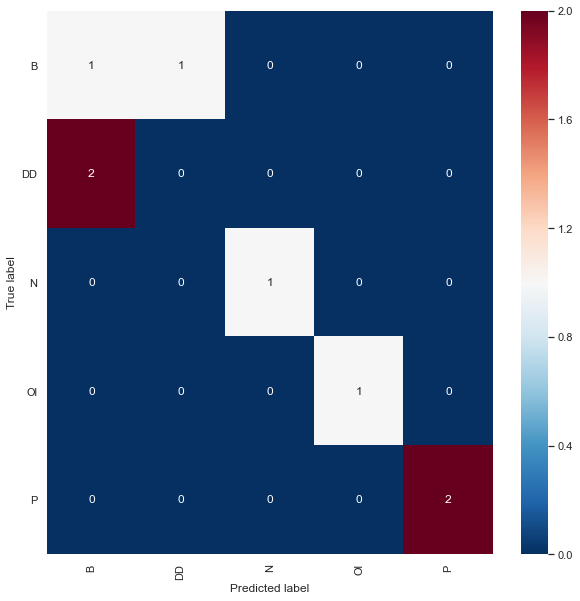

true


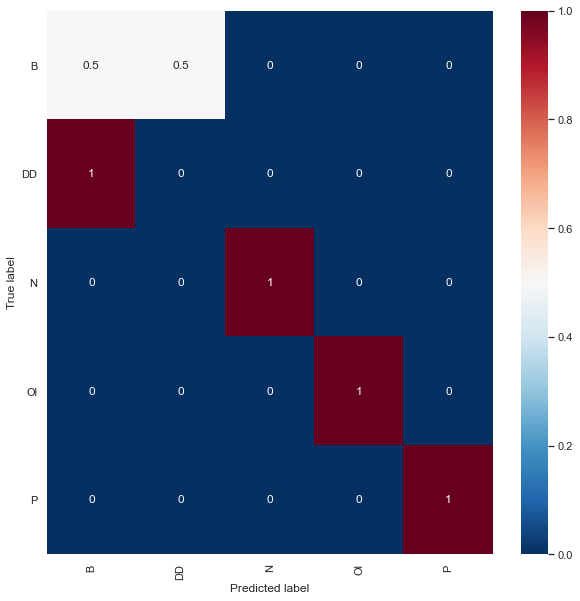

pred


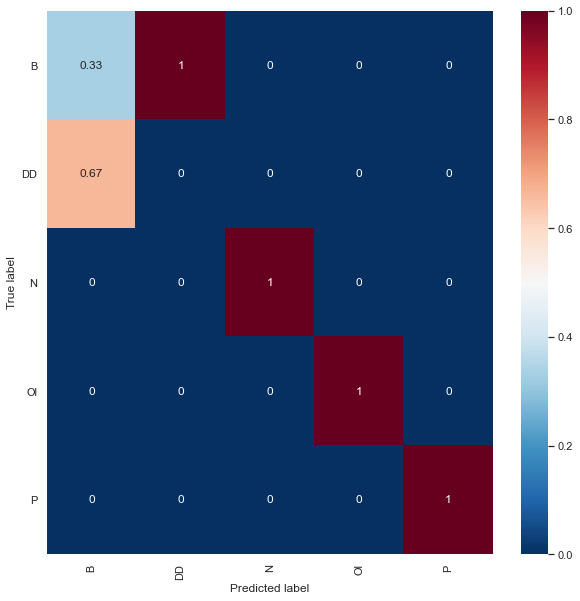

In [44]:
final_params = {'n_neighbors': 3,
                'p': 1,
                'weights': 'distance'}

scoring_funcs={accuracy_score: {},
               recall_score: {'average': 'macro'},
               precision_score: {'average': 'macro'},
               f1_score: {'average': 'macro'},
               cohen_kappa_score: {}}

knn_clf, train_scores, test_scores, predictions = ml.run_ml(
    clf=KNeighborsClassifier, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='train', fixed_params=fixed_params,
    tuned_params=final_params, train_scoring_func='accuracy', test_scoring_funcs=scoring_funcs,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

So, increasing the number of components used in training does very little to improve model accuracy (in fact it actually decreases slightly, but it's difficult to assess whether this difference is "real" or not given the wide variation present in the accuracy scores obtained during cross-validation as a result of the small size of the dataset). This result is as to be expected given that ~98% of the signal is in the first 3 components, so introduction of additional components will introduce very little extra signal and much more noise, which increases the risk of overfitting.

How well does the trained classifier predict the different classes?

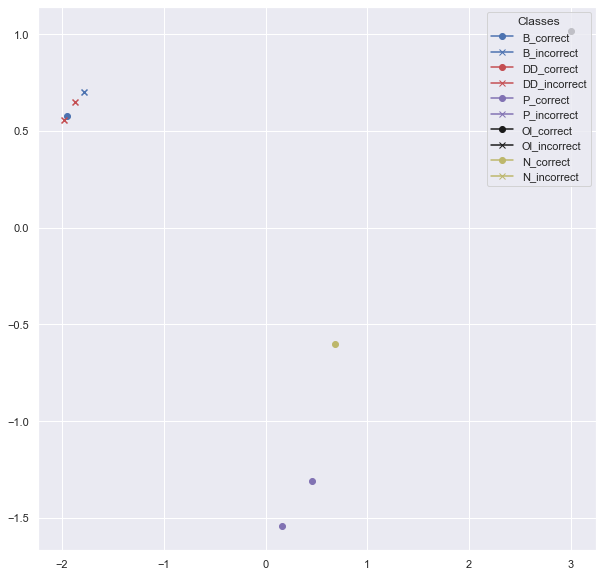

In [45]:
X_test_reduced = pca_fitted.transform(X=ml.test_x)
y_test_pred_hue = []
for index, y in np.ndenumerate(ml.test_y):
    if predictions[index] == y:
        y_test_pred_hue.append('{}_correct'.format(y))
    else:
        y_test_pred_hue.append('{}_incorrect'.format(y))

# Plots transformed data on 2D scatter plot
x_train_pca = plot_scatter(
    x_data=X_test_reduced, y_data=y_test_pred_hue, dimensions=2,
    categories=['B_correct', 'B_incorrect', 'DD_correct', 'DD_incorrect', 'P_correct', 'P_incorrect',
                'Ol_correct', 'Ol_incorrect', 'N_correct', 'N_incorrect'],
    results_dir=ml.results_dir, plot_id='Test_data'
)

#### - ML on all FA data (13 classes)

In [46]:
ml = RunML(
    results_dir='/Users/ks17361/Lab_work_Dek_Woolfson/BADASS/array_sensing/Analysis/Standard_array/FAs/'
                'All_FAs_ML_results/', fluor_data=fa_fluor_data.ml_fluor_data
)

In [47]:
ml.split_train_test_data(randomise=True, percent_test=0.2, test_analytes=[])

On all of the data (training and test sets):

- Visualise correlation between the initial 14 features

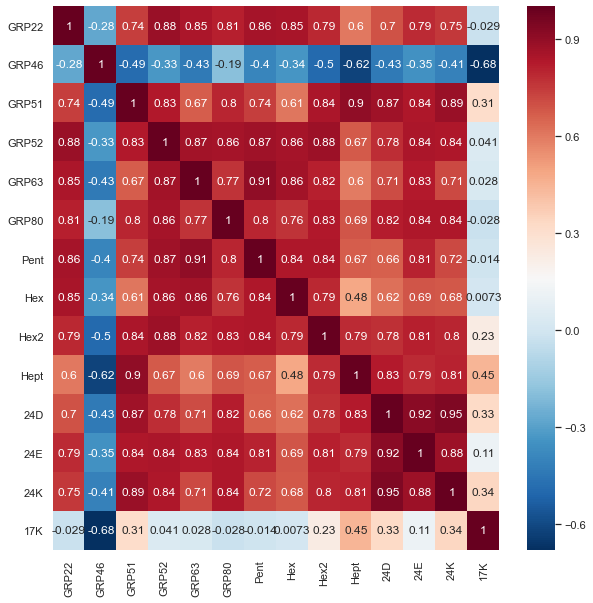

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
GRP22,1.000000,-0.275413,0.743049,0.882251,0.847442,0.813843,0.860787,0.854284,0.791248,0.602083,0.697225,0.788952,0.752754,-0.028640
GRP46,-0.275413,1.000000,-0.486698,-0.327750,-0.432924,-0.194248,-0.396475,-0.337748,-0.496028,-0.620438,-0.434903,-0.346704,-0.411421,-0.681008
GRP51,0.743049,-0.486698,1.000000,0.830513,0.669111,0.802263,0.742778,0.608846,0.844581,0.903399,0.870467,0.836744,0.887088,0.314123
GRP52,0.882251,-0.327750,0.830513,1.000000,0.866170,0.858604,0.874063,0.857371,0.878406,0.672470,0.779091,0.844920,0.839483,0.040571
GRP63,0.847442,-0.432924,0.669111,0.866170,1.000000,0.767047,0.905186,0.863885,0.815393,0.599369,0.708365,0.826272,0.712110,0.027543
GRP80,0.813843,-0.194248,0.802263,0.858604,0.767047,1.000000,0.800069,0.764661,0.830264,0.687296,0.817315,0.838293,0.840229,-0.027894
Pent,0.860787,-0.396475,0.742778,0.874063,0.905186,0.800069,1.000000,0.841279,0.837038,0.670299,0.663513,0.809195,0.716113,-0.014040
Hex,0.854284,-0.337748,0.608846,0.857371,0.863885,0.764661,0.841279,1.000000,0.790366,0.481575,0.624384,0.685509,0.682486,0.007289
Hex2,0.791248,-0.496028,0.844581,0.878406,0.815393,0.830264,0.837038,0.790366,1.000000,0.787358,0.776377,0.810032,0.799658,0.230199
Hept,0.602083,-0.620438,0.903399,0.672470,0.599369,0.687296,0.670299,0.481575,0.787358,1.000000,0.826136,0.786216,0.806031,0.446936


In [48]:
ml.calc_feature_correlations(train_data=ml.fluor_data)

- Measure the relative importances of the initial 14 features

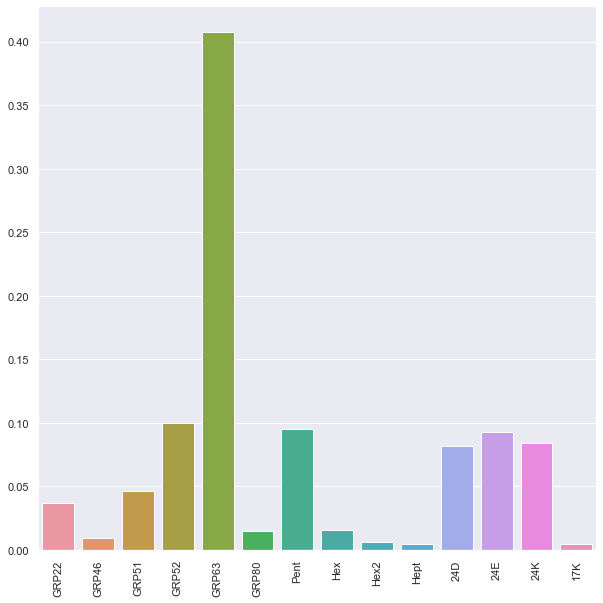

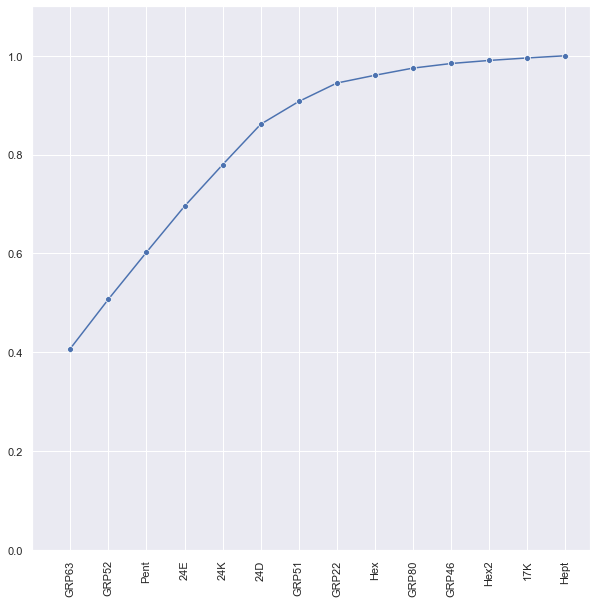

,Feature,Score
0,GRP63,0.407339
1,GRP52,0.099850
2,Pent,0.095176
3,24E,0.093171
4,24K,0.084088
5,24D,0.081809
6,GRP51,0.046074
7,GRP22,0.037276
8,Hex,0.015729
9,GRP80,0.014512


In [49]:
from sklearn.feature_selection import f_classif
ml.calc_feature_importances_kbest(x_train=ml.x, y_train=ml.y, features=ml.features, method_classif=f_classif)

- Run PCA to determine the number of components to use in all following cross-validation splits

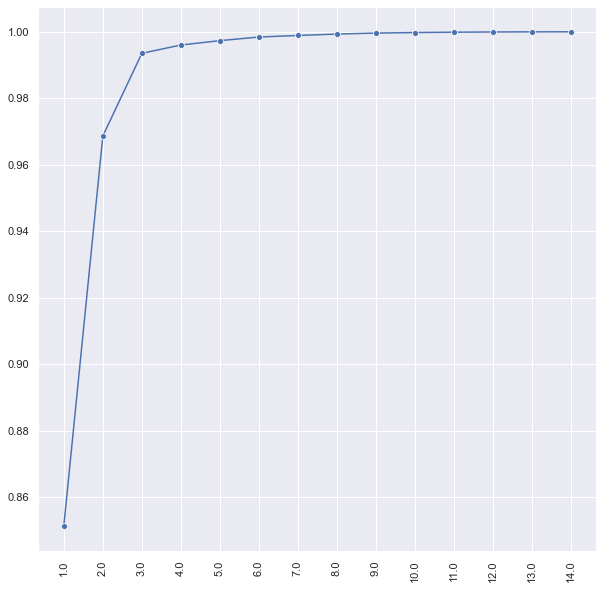

In [50]:
all_features_pca = ml.run_pca(x_train=ml.x, features=ml.features)

Contributions of the 14 barrels to each principal component (see the Scree plot above for how much of the signal in the data is explained by successive principal components)

In [51]:
pca_components = OrderedDict({'Component': [int(n) for n in range(1, 15)]})
for index, feature in enumerate(ml.features):
    pca_components[feature] = all_features_pca.components_[:,index]
pca_components = pd.DataFrame(pca_components)
pca_components = pca_components.set_index('Component', drop=True)

In [52]:
pca_components

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
Component,,,,,,,,,,,,,,
1,-0.055700,0.975990,-0.048179,-0.077471,-0.078332,-0.022230,-0.066458,-0.060130,-0.028128,-0.038493,-0.066463,-0.070699,-0.064532,-0.074179
2,-0.262922,-0.186340,-0.286715,-0.321631,-0.322386,-0.300022,-0.277268,-0.228141,-0.123825,-0.153830,-0.329795,-0.329953,-0.327802,0.153435
3,0.012528,0.099408,0.103656,0.028057,0.010551,0.029372,-0.034655,-0.013480,0.025403,0.188830,0.064711,0.038711,0.065741,0.964242
4,0.074730,0.027101,-0.200909,0.071694,0.040731,-0.056857,-0.017936,0.781849,-0.014751,-0.549662,-0.065954,-0.053685,-0.035482,0.144349
5,-0.159717,-0.019150,0.176043,-0.146036,-0.197636,0.423135,0.079129,0.407247,0.312960,0.463880,-0.343800,-0.245285,-0.189027,-0.066095
6,-0.509653,-0.023888,-0.234245,-0.143587,-0.057417,0.450839,-0.364359,0.056113,-0.039280,-0.047085,0.549219,0.121632,0.033343,-0.020731
7,-0.358794,0.005128,0.064113,0.395708,0.135793,0.013861,0.039374,-0.255124,0.683735,-0.357653,-0.097181,-0.135455,0.003485,0.045417
8,0.222120,-0.013513,-0.308469,-0.115823,0.039523,0.650071,0.382992,-0.296568,-0.141718,-0.307964,-0.230470,0.000629,-0.058626,0.107904
9,-0.196474,0.029584,-0.561832,-0.168260,0.261309,-0.291682,0.524727,0.083450,0.193612,0.291361,0.172683,0.079872,-0.147455,0.023945


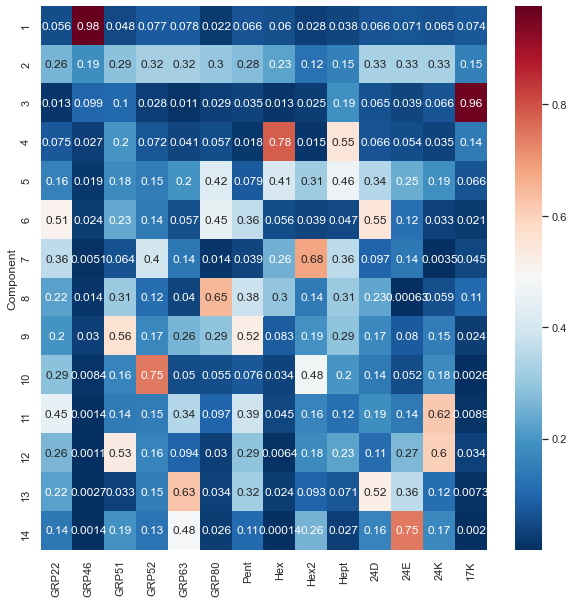

In [53]:
sns.heatmap(data=pca_components.abs(), cmap='RdBu_r', annot=True, xticklabels=True, yticklabels=True)

Relative contribution to the different components of each barrel

In [54]:
col_sums = copy.deepcopy(pca_components).abs().sum(axis=0)
relative_pca_components = copy.deepcopy(pca_components.abs()).div(col_sums, axis=1)

In [55]:
relative_pca_components

,GRP22,GRP46,GRP51,GRP52,GRP63,GRP80,Pent,Hex,Hex2,Hept,24D,24E,24K,17K
Component,,,,,,,,,,,,,,
1,0.017355,0.699591,0.015829,0.027669,0.028546,0.008964,0.022376,0.026229,0.010310,0.012644,0.021852,0.026759,0.024703,0.044828
2,0.081923,0.133568,0.094199,0.114871,0.117485,0.120976,0.093355,0.099517,0.045389,0.050528,0.108433,0.124883,0.125484,0.092725
3,0.003904,0.071256,0.034056,0.010020,0.003845,0.011843,0.011668,0.005880,0.009312,0.062025,0.021276,0.014652,0.025166,0.582718
4,0.023285,0.019426,0.066008,0.025606,0.014843,0.022926,0.006039,0.341048,0.005407,0.180546,0.021685,0.020319,0.013583,0.087234
5,0.049766,0.013727,0.057838,0.052157,0.072023,0.170618,0.026642,0.177644,0.114717,0.152370,0.113038,0.092837,0.072360,0.039943
6,0.158800,0.017123,0.076960,0.051282,0.020924,0.181788,0.122678,0.024477,0.014398,0.015466,0.180578,0.046036,0.012764,0.012528
7,0.111795,0.003676,0.021064,0.141327,0.049486,0.005589,0.013257,0.111287,0.250627,0.117477,0.031952,0.051268,0.001334,0.027447
8,0.069209,0.009686,0.101346,0.041366,0.014403,0.262123,0.128952,0.129365,0.051947,0.101156,0.075776,0.000238,0.022442,0.065209
9,0.061218,0.021206,0.184588,0.060094,0.095227,0.117613,0.176674,0.036402,0.070969,0.095703,0.056777,0.030231,0.056446,0.014471


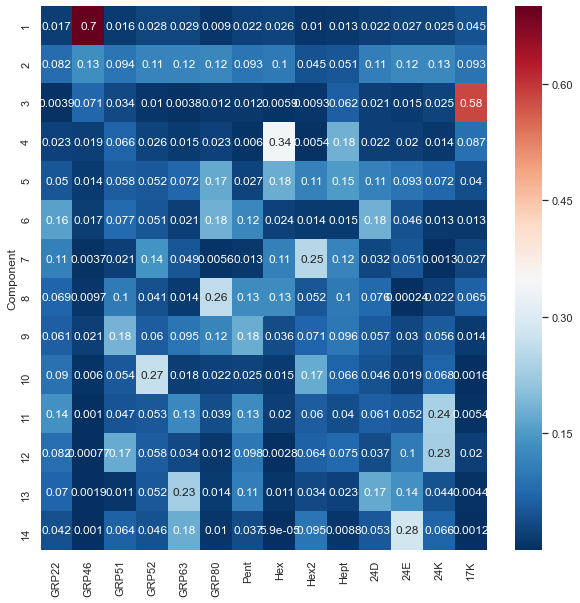

In [56]:
sns.heatmap(data=relative_pca_components.abs(), cmap='RdBu_r', annot=True, xticklabels=True, yticklabels=True)

Scatter plots of data transformed to PCA dimensions

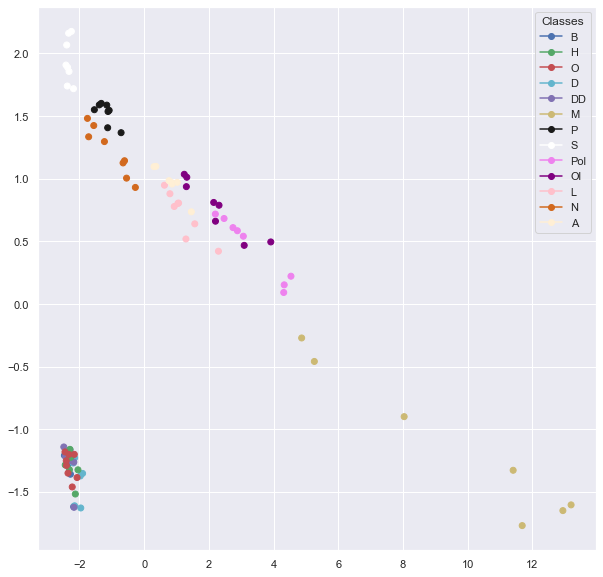

In [58]:
# Runs PCA and transforms data to 2 dimensions 
from sklearn.decomposition import PCA
pca_2d = PCA(n_components=2)
pca_fitted_2d = pca_2d.fit(X=ml.x)
X_reduced_2d = pca_fitted_2d.transform(X=ml.x)

# Plots transformed data on 3D scatter plot
x_train_pca_2d = plot_scatter(
    x_data=X_reduced_2d, y_data=ml.y, dimensions=2, categories=['B', 'H', 'O', 'D', 'DD', 'M', 'P',
                                                                'S', 'Pol', 'Ol', 'L', 'N', 'A'],
    results_dir=ml.results_dir, plot_id='All_data_2D'
)

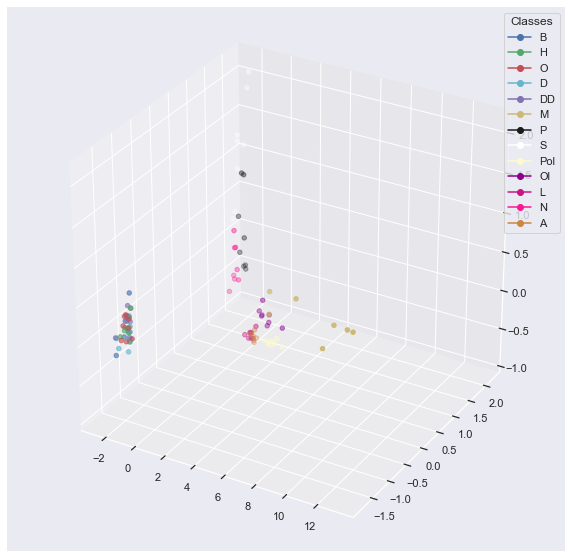

In [59]:
# Runs PCA and transforms data to 3 dimensions 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_fitted = pca.fit(X=ml.x)
X_reduced = pca_fitted.transform(X=ml.x)

# Plots transformed data on 3D scatter plot
x_train_pca = plot_scatter(
    x_data=X_reduced, y_data=ml.y, dimensions=3, categories=['B', 'H', 'O', 'D', 'DD', 'M', 'P',
                                                             'S', 'Pol', 'Ol', 'L', 'N', 'A'],
    results_dir=ml.results_dir, plot_id='All_data_3D'
)

~99% of the variation in the data can be accounted for with 3 features, so will transform the data to 3 (rather than 14) features

In [60]:
n_components = 3

Runs randomized search to spot check 6 different ML algorithms with 25 different combinations of the parameters to be optimised. Cross-validation loop involves:
- standardisation of the data (i.e. subtraction of the mean and division by the standard deviation) for each feature
- transformation from 14 to 3 dimensions using PCA
- randomized search of 25 different hyperparameter combinations for the selected ML algorithm

In [62]:
cv_folds = 5  # Number of splits in cross-validation
n_iter = 25  # Number of parameter combinations to test in RandomisedSearchCV

resampling_methods = ['no_balancing']

score_dict = OrderedDict({'Algorithm': [],
                          'Resampling_method': [],
                          'Best_params': [],
                          'Best_accuracy_score': [],
                          'Mean_accuracy_score': [],
                          'Std_dev_accuracy_score': []})

log_reg = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(metric='minkowski', n_jobs=-1)
linear_svc = LinearSVC(dual=False)
svc = SVC()
naive_bayes = GaussianNB()

algorithms = [log_reg, knn, naive_bayes, linear_svc, svc]
for algorithm in algorithms:
    params = ml.define_tuned_model_params(clf=algorithm, x_train=ml.train_x)  # Actual number of x samples will be
    # different owing to oversampling, but don't want to hard code this selection into the pipeline, so for now
    # this estimate will do
    spot_checks, *_ = ml.run_algorithm(
        clf=algorithm, x_train=ml.train_x, y_train=ml.train_y, train_groups=ml.train_groups, x_test=ml.test_x,
        y_test=ml.test_y, n_components_pca=n_components, run='randomsearch', params=params,
        train_scoring_func='accuracy', test_scoring_funcs=None, resampling_method=resampling_methods,
        n_iter=n_iter, cv_folds=cv_folds
    )

    for method, spot_check in spot_checks.items():
        score_dict['Algorithm'].append(type(algorithm).__name__)
        score_dict['Resampling_method'].append(method)
        score_dict['Best_params'].append(spot_check.best_params_)
        score_dict['Best_accuracy_score'].append(spot_check.best_score_)
        score_dict['Mean_accuracy_score'].append(np.nanmean(spot_check.cv_results_['mean_test_score']))
        score_dict['Std_dev_accuracy_score'].append(np.nanmean(spot_check.cv_results_['std_test_score']))

        print('\n\n\n\n\n')
        print('{}: {}'.format(type(algorithm).__name__, method))
        print('Best parameters: {}'.format(spot_check.best_params_))
        print('Best score: {}'.format(spot_check.best_score_))

        selected_params = spot_check.cv_results_['params']
        selected_params_score = spot_check.cv_results_['mean_test_score']
        print('All parameter combinations tested:')
        for i in range(len(selected_params)):
            print(i+1, selected_params[i], round(selected_params_score[i], 3))
        
score_df = pd.DataFrame(score_dict)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Randomised search with cross-validation results:
Best parameters: {'LogisticRegression__solver': 'sag', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 10000.0}
Best score: 0.6360294117647058






LogisticRegression: no_balancing
Best parameters: {'LogisticRegression__solver': 'sag', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'multinomial', 'LogisticRegression__C': 10000.0}
Best score: 0.6360294117647058
All parameter combinations tested:
1 {'LogisticRegression__solver': 'lbfgs', 'LogisticRegression__penalty': 'l1', 'LogisticRegression__multi_class': 'ovr', 'LogisticRegression__C': 1.0} nan
2 {'LogisticRegression__solver': 'newton-cg', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'ovr', 'LogisticRegression__C': 0.03162277660168379} 0.268
3 {'LogisticRegression__solver': 'sag', 'LogisticRegression__penalty': 'l2', 'LogisticRegression__multi_class': 'ovr', 'LogisticReg

Randomised search with cross-validation results:
Best parameters: {'LinearSVC__C': 2.8284271247461903}
Best score: 0.5492647058823529






LinearSVC: no_balancing
Best parameters: {'LinearSVC__C': 2.8284271247461903}
Best score: 0.5492647058823529
All parameter combinations tested:
1 {'LinearSVC__C': 1.4142135623730951} 0.501
2 {'LinearSVC__C': 0.125} 0.304
3 {'LinearSVC__C': 0.1767766952966369} 0.304
4 {'LinearSVC__C': 64.0} 0.537
5 {'LinearSVC__C': 0.5} 0.39
6 {'LinearSVC__C': 90.50966799187809} 0.537
7 {'LinearSVC__C': 4.0} 0.537
8 {'LinearSVC__C': 0.04419417382415922} 0.279
9 {'LinearSVC__C': 0.0625} 0.292
10 {'LinearSVC__C': 5.656854249492381} 0.537
11 {'LinearSVC__C': 0.25} 0.366
12 {'LinearSVC__C': 724.0773439350247} 0.538
13 {'LinearSVC__C': 8192.0} 0.525
14 {'LinearSVC__C': 256.0} 0.538
15 {'LinearSVC__C': 2.8284271247461903} 0.549
16 {'LinearSVC__C': 45.254833995939045} 0.525
17 {'LinearSVC__C': 16384.0} 0.525
18 {'LinearSVC__C': 1448.1546878700494} 0.525
19 {'LinearSVC__C':

In [63]:
score_df

,Algorithm,Resampling_method,Best_params,Best_accuracy_score,Mean_accuracy_score,Std_dev_accuracy_score
0,LogisticRegression,no_balancing,"{'LogisticRegression__solver': 'sag', 'Logisti...",0.636029,0.400654,0.063116
1,KNeighborsClassifier,no_balancing,"{'KNeighborsClassifier__weights': 'distance', ...",0.586029,0.462500,0.070165
2,GaussianNB,no_balancing,{},0.548529,0.548529,0.050000
3,LinearSVC,no_balancing,{'LinearSVC__C': 2.8284271247461903},0.549265,0.480324,0.070518
4,SVC,no_balancing,"{'SVC__gamma': 0.00390625, 'SVC__C': 11585.237...",0.698529,0.445471,0.069330


So, from this spot check, a **support vector classifier with a radial basis function kernel** does a good job.

So, run hyperparameter optimisation for SVC.

In [64]:
fixed_params = ml.define_fixed_model_params(clf=SVC())
random_tuned_params = ml.define_tuned_model_params(clf=SVC(), x_train=ml.train_x)

svc_random_search = ml.run_ml(
    clf=SVC, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='random search', fixed_params=fixed_params,
    tuned_params=random_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Randomised search with cross-validation results:
Best parameters: {'SVC__gamma': 0.015625, 'SVC__C': 1024.0}
Best score: 0.6595588235294118


In [66]:
grid_tuned_params = {'C': np.linspace(100, 10000, 100),
                     'gamma': np.linspace(0.001, 0.1, 100)}

svc_grid_search = ml.run_ml(
    clf=SVC, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='grid search', fixed_params=fixed_params,
    tuned_params=grid_tuned_params, train_scoring_func='accuracy', test_scoring_funcs=None,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

Grid search with cross-validation results:
Best parameters: {'SVC__C': 3600.0, 'SVC__gamma': 0.047}
Best score: 0.7073529411764705


### So, optimal hyperparameter combination:
- C = 3600
- gamma = 0.047

Model cross-validation score: [0.64705882 0.58823529 0.5        0.6875     0.75      ]
accuracy_score: 0.7
recall_score: 0.6923076923076923
precision_score: 0.641025641025641
f1_score: 0.6538461538461539
cohen_kappa_score: 0.6747967479674797
None


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


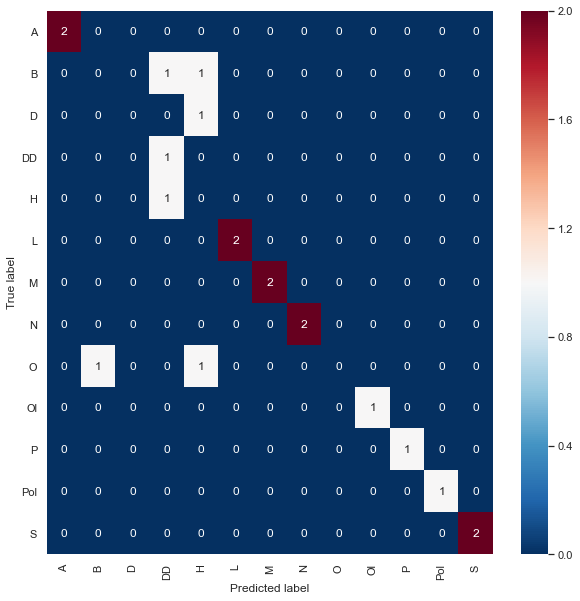

true


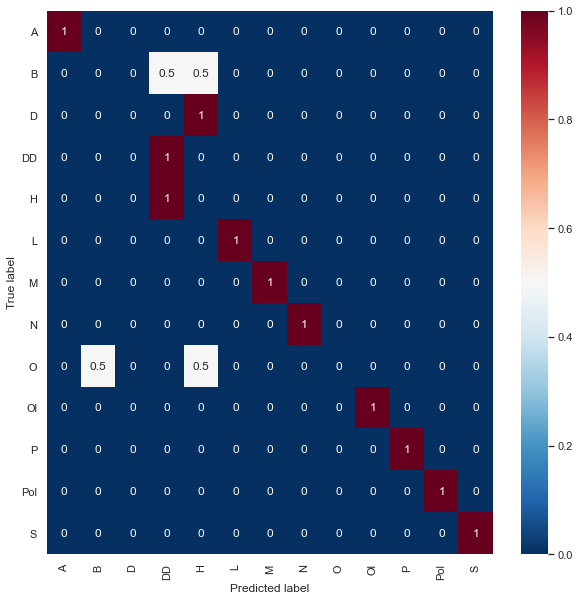

pred


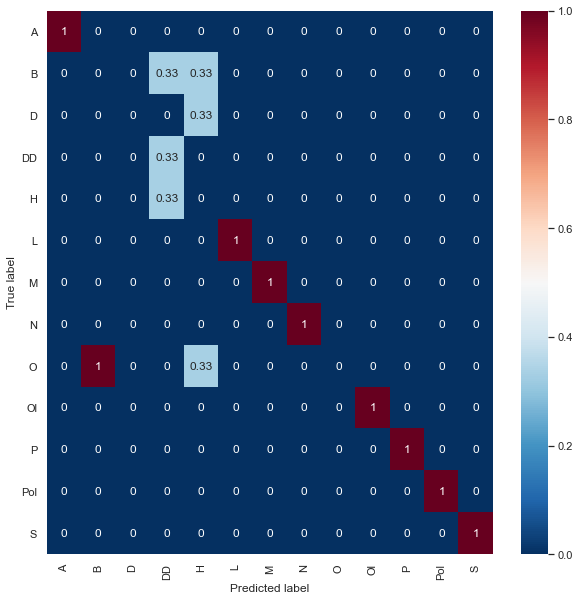

In [67]:
final_params = {'C': 3600,
                'gamma': 0.047}

scoring_funcs={accuracy_score: {},
               recall_score: {'average': 'macro'},
               precision_score: {'average': 'macro'},
               f1_score: {'average': 'macro'},
               cohen_kappa_score: {}}

svc_clf, train_scores, test_scores, predictions = ml.run_ml(
    clf=SVC, x_train=ml.train_x, y_train=ml.train_y, train_groups=None, x_test=ml.test_x,
    y_test=ml.test_y, n_components_pca=n_components, run='train', fixed_params=fixed_params,
    tuned_params=final_params, train_scoring_func='accuracy', test_scoring_funcs=scoring_funcs,
    resampling_method=['no_balancing'], n_iter='', cv_folds=cv_folds
)

So, clearly the model does a good job at distinguishing the longer chain and unsaturated fatty acids, but struggles more with the shorter fatty acids.

How well does the trained classifier predict the different classes?

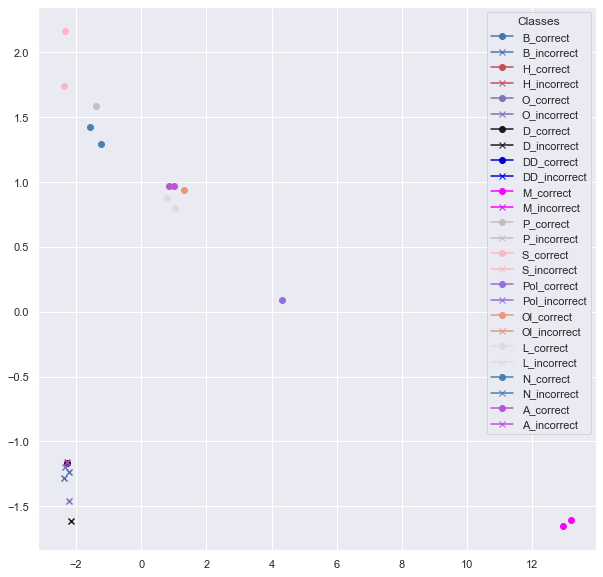

In [73]:
X_test_reduced = pca_fitted.transform(X=ml.test_x)
y_test_pred_hue = []
for index, y in np.ndenumerate(ml.test_y):
    if predictions[index] == y:
        y_test_pred_hue.append('{}_correct'.format(y))
    else:
        y_test_pred_hue.append('{}_incorrect'.format(y))

# Plots transformed data on 2D scatter plot
x_train_pca = plot_scatter(
    x_data=X_test_reduced, y_data=y_test_pred_hue, dimensions=2,
    categories=['B_correct', 'B_incorrect', 'H_correct', 'H_incorrect', 'O_correct', 'O_incorrect',
                'D_correct', 'D_incorrect', 'DD_correct', 'DD_incorrect', 'M_correct', 'M_incorrect',
                'P_correct', 'P_incorrect', 'S_correct', 'S_incorrect', 'Pol_correct', 'Pol_incorrect',
                'Ol_correct', 'Ol_incorrect', 'L_correct', 'L_incorrect', 'N_correct', 'N_incorrect',
                'A_correct', 'A_incorrect'],
    results_dir=ml.results_dir, plot_id='Test_data'
)